In [251]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
import math
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
import matplotlib.pyplot as mpl
from qiskit.circuit.library import MCMT, MCMTVChain
from qiskit.circuit import Gate
from random import randint
import random
from qiskit.circuit.library.basis_change import QFT
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.quantum_info import Statevector
from qiskit import Aer, execute

import qiskit as qk
from qiskit import QuantumCircuit
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
import math
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt


Это вспомагательная функция для построения пикселей со знаечниями.

In [252]:
def plot_array(arr, fig, ax):
    #
    im = ax.imshow(arr, cmap="gray")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            text = ax.text(j, i, arr[i, j],
                        ha="center", va="center", color="b", fontsize = 32)


Тут ввиде списка нужно задать само изображение, и поместить его в image_10

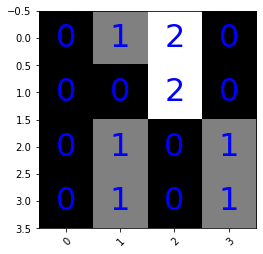

In [253]:
image_10 = [0,1,2,0,0,0,2,0,0,1,0,1,0,1,0,1]
image = np.array(["000"]*16, dtype=str)

for i,x in enumerate(image_10):
    num = format(x, f"0{len(image[0])}b")
    image[i] = num

fig, ax = plt.subplots()
plot_array(np.array(image_10).reshape(4,4), fig, ax)

#### Реализация shift +1

In [254]:
# Эта функция реализует увеличене x/y на единицу (x+1)/(y+1)
def shifting_plus(circ, q_reg): 
    n = q_reg.size
    for i in range(1, n)[::-1]:
        circ.mct(q_reg[0:i], q_reg[i], mode='noancilla')      
    circ.x(q_reg[0])

#### Реализация shift -1

In [255]:
# Эта функция реализует уменьшение x/y на единицу (x-1)/(y-1).
def shifting_minus(circ, q_reg): #Начиная с какого кубита будут применяться управляющие x гейты
    n = q_reg.size
    circ.x(q_reg[0:n])
    for i in range(1, n)[::-1]:
        circ.mct(q_reg[0:i], q_reg[i], mode='noancilla')      
    circ.x(q_reg[0])
    #circ.barrier()
    circ.x(q_reg[0:n])

#### Функция для построения модели NEQR

In [256]:
def build_neqr_test(image: np.ndarray, NEQR_circuit, position_value_x, position_value_y, color_value):

    image_size = len(image)

    position_num_y = position_value_y.size
    position_num_x = position_value_x.size
    position_num = position_num_y + position_num_x


    intensity_num = len(image[0])
    intensity_num = color_value.size
   
    
    for n in range(image_size):
        value = format(n, f"0{position_num}b")
        for position, position_value_value in enumerate(value[::-1]):
            if(position_value_value =="0"):
                NEQR_circuit.x(position + intensity_num*8) 
        for position_1, px_value_1 in enumerate(image[n][::-1]):
            if(px_value_1 == "1"):
                NEQR_circuit.mct([*position_value_x, *position_value_y], color_value[position_1], mode='noancilla')  
        for position, position_value_value in enumerate(value[::-1]):
            if(position_value_value =="0"):
                NEQR_circuit.x(position + intensity_num*8)                     
        NEQR_circuit.barrier()  


##### Создание места для 9 копий

In [257]:
image_size = len(image)

intensity_num = len(image[0])
NEQR_circuit = QuantumCircuit()

for i in range(8):
    img = QuantumRegister(intensity_num, f"image_{i}")
    NEQR_circuit.add_register(img)

position_num_y = int(math.log(image_size, 2)/2)
position_num_x = int(math.log(image_size, 2)/2)
position_value_x = QuantumRegister(position_num_x, "position_value_x")
position_value_y = QuantumRegister(position_num_y, "position_value_y")

NEQR_circuit.add_register(position_value_x)
NEQR_circuit.add_register(position_value_y)

NEQR_circuit.h(NEQR_circuit.qregs[8][:]+NEQR_circuit.qregs[9][:]) #Переделать в автоматическое определение регистра, сейчас в ручную это делается


##### 1 копия

In [258]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[0])

shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1)   


##### 2 копия

In [259]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[1])

shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1)  

##### 3 копия

In [260]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[2])

shifting_minus(NEQR_circuit, NEQR_circuit.qregs[9])# (y-1) 
shifting_minus(NEQR_circuit, NEQR_circuit.qregs[9])# (y-1) 

shifting_plus(NEQR_circuit, NEQR_circuit.qregs[8])# (x+1) 
shifting_plus(NEQR_circuit, NEQR_circuit.qregs[8])# (x+1) 

##### 4 копия

In [261]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[3])

shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1) 
shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1) 

##### 5 копия

In [262]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[4])

shifting_minus(NEQR_circuit, NEQR_circuit.qregs[9])# (y-1) 

##### 6 копия

In [263]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[5])

shifting_minus(NEQR_circuit, NEQR_circuit.qregs[9])# (y-1) 
shifting_minus(NEQR_circuit, NEQR_circuit.qregs[8])# (x-1) 

##### 7 копия

In [264]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[6])

shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1) 
shifting_plus(NEQR_circuit, NEQR_circuit.qregs[9])# (y+1) 

##### 8 копия

In [265]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[7])

shifting_minus(NEQR_circuit, NEQR_circuit.qregs[9])# (y-1) 

##### 9 копия

In [266]:
#build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[8])

#### Реализуем сумму

Пока предполагается что сумма не выходит за пределелы 8 кубит, потом можно будет добавить необходимое количество кубит

%adder = DraperQFTAdder(2, kind = "fixed")

%NEQR_circuit = NEQR_circuit.compose(adder, qubits=[color_value[6], color_value[7]] + [position_x[0], position_x[1]])

In [267]:
adder = DraperQFTAdder(intensity_num, kind = "fixed")
for i in range(7):
    NEQR_circuit = NEQR_circuit.compose(adder, qubits=NEQR_circuit.qregs[i][0:intensity_num] + NEQR_circuit.qregs[i+1][0:intensity_num])

### Измерение

In [269]:
from qiskit import transpile

#a = ClassicalRegister(size = 7, name = "clbits")

#NEQR_circuit.add_register(a)


#NEQR_circuit.measure([27,26,25,24,23,22,21], [6,5,4,3,2,1,0])

NEQR_circuit.measure_all()


In [270]:
#NEQR_circuit.measure_all()
#
extended_stabilizer_simulator = AerSimulator(method='statevector', extended_stabilizer_sampling_method = 'norm_estimation', device='GPU')
extended_stabilizer_simulator.set_options(precision='single')

tsmall_circ = transpile(NEQR_circuit, extended_stabilizer_simulator)
print("Transpiled")


result = extended_stabilizer_simulator.run(tsmall_circ, shots=100000).result()
counts = result.get_counts(0)
print('100 shots in {}s'.format(result.time_taken))

Transpiled
100 shots in 28.399163722991943s


In [271]:
from collections import defaultdict
import textwrap

position_size = 4
splitter = lambda x: (int(x[0][:4],2), x[1],  x[0][4:])
elements = list(map(splitter, zip(counts.keys(), counts.values())))

d = defaultdict(list)    
for x in elements:
    if(x[1] > 10):
        d[x[0]].append((x[1], list(map(lambda x: int(x,2),textwrap.wrap(x[2],3)))))

In [272]:

res = []

for x in d:
    res.append((x, max(d[x])[1:]))

In [273]:
def get_shift_array(shift_ind):
    pixels = []
    for i,one_pos in enumerate(sorted(res)):
        pixels.append(one_pos[1][0][shift_ind])
    pixels = np.array(pixels).reshape(4,4)
    return pixels

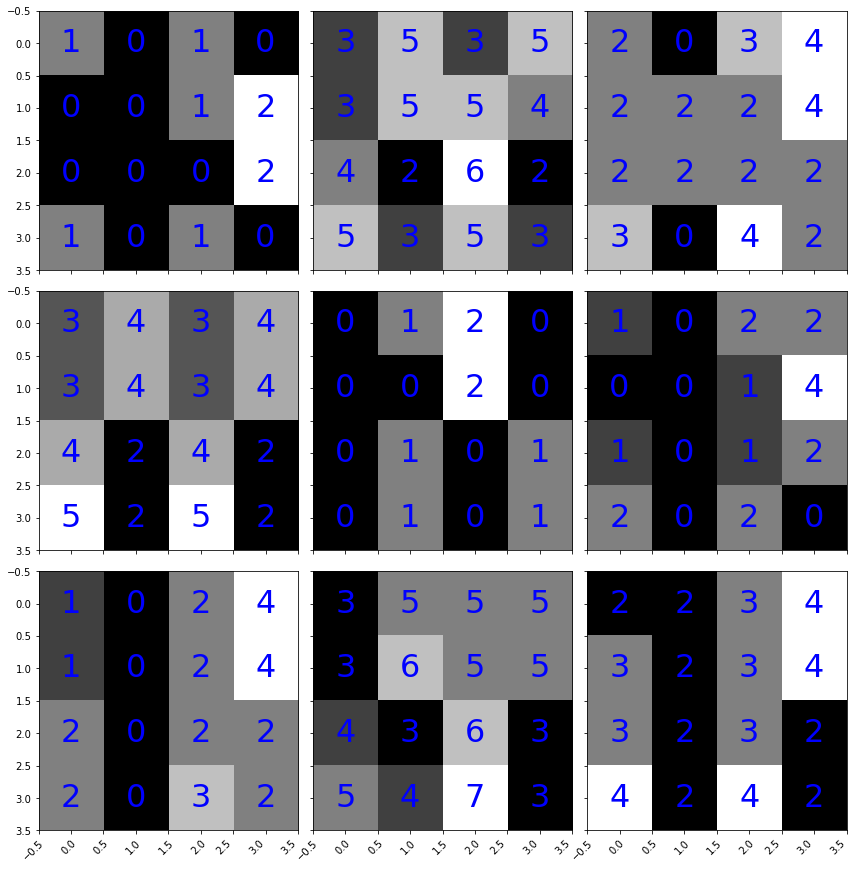

In [274]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, sharex='all', sharey='all', figsize=(12,12))


plot_array(np.array(image_10).reshape(4,4), fig, axes[1,1])



plot_array(get_shift_array(7), fig, axes[0,0])
plot_array(get_shift_array(6), fig, axes[1,2])

plot_array(get_shift_array(5), fig, axes[2,0])



plot_array(get_shift_array(4), fig, axes[0,2])

plot_array(get_shift_array(3), fig, axes[2,2])

plot_array(get_shift_array(2), fig, axes[1,0])

plot_array(get_shift_array(1), fig, axes[0,1])


plot_array(get_shift_array(0), fig, axes[2,1])




fig.tight_layout()
plt.show()

In [275]:
res

[(7, ([5, 4, 4, 4, 4, 4, 4, 2],)),
 (0, ([3, 3, 3, 2, 2, 1, 1, 1],)),
 (5, ([6, 5, 4, 2, 2, 0, 0, 0],)),
 (10, ([6, 6, 4, 3, 2, 2, 1, 0],)),
 (11, ([3, 2, 2, 2, 2, 2, 2, 2],)),
 (15, ([3, 3, 2, 2, 2, 2, 0, 0],)),
 (3, ([5, 5, 4, 4, 4, 4, 2, 0],)),
 (1, ([5, 5, 4, 2, 0, 0, 0, 0],)),
 (9, ([3, 2, 2, 2, 2, 0, 0, 0],)),
 (6, ([5, 5, 3, 3, 2, 2, 1, 1],)),
 (4, ([3, 3, 3, 3, 2, 1, 0, 0],)),
 (13, ([4, 3, 2, 2, 0, 0, 0, 0],)),
 (8, ([4, 4, 4, 3, 2, 2, 1, 0],)),
 (2, ([5, 3, 3, 3, 3, 2, 2, 1],)),
 (14, ([7, 5, 5, 4, 4, 3, 2, 1],)),
 (12, ([5, 5, 5, 4, 3, 2, 2, 1],))]